# Supervised learning algorithms to detect spam messages

The objective is to compare different supervised machine learning algorthms to detect sapm messages.
For this purpose 3 follwing algorithms are compared: 
- Decision tree classifier
- Adaboost ensemble classifier
- Support vector machine

To classify messages as spam or non-spam, the algortihms are trained on 5572 labeled messages (labeled either spam or ham, i.e. not spam) that are already classified by humans.
 
The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The dataset can be downloaded directly from this [link](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). The data collection process is described in more details on this [page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where there are also some of the authors' papers.




--------
Exploring dataset
-----------

In [1]:
# installing libraries

#%pip install pandas
#%pip install numpy
#!pip install matplotlib
#%pip install -U scikit-learn
#%pip install seaborn

In [28]:
# importing ibraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
import time
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from matplotlib.colors import Normalize

In [29]:
# reading the data
data = pd.read_csv('SMSSpamCollection.txt', sep='\t', header=None,
                  names=['Label', 'SMS'])

In [30]:
# some samples from data
data.sample(20)

,Label,SMS
2572,ham,… and don‘t worry we‘ll have finished by march...
1003,ham,Yes..he is really great..bhaji told kallis bes...
1968,ham,Even i cant close my eyes you are in me our va...
5355,ham,Living is very simple.. Loving is also simple....
4784,ham,Especially since i talk about boston all up in...
2212,ham,Just gettin a bit arty with my collages at the...
625,ham,"Nah it's straight, if you can just bring bud o..."
3889,ham,ok....take care.umma to you too...
2804,spam,FreeMsg>FAV XMAS TONES!Reply REAL
4149,spam,Please call Amanda with regard to renewing or ...


In [31]:
# number of rows and columns in dataset
data.shape

(5572, 2)

Dataset includes 5572 messages which are labeled either as spam or ham

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


There are no null data in the dataset

Label
ham     86.6
spam    13.4
Name: proportion, dtype: float64


([<matplotlib.patches.Wedge at 0x7f41c02ac100>,
 [Text(-1.0038714981945518, 0.4497132587689916, 'ham (not spam)'),
  Text(1.0038714981945516, -0.4497132587689922, 'spam')])

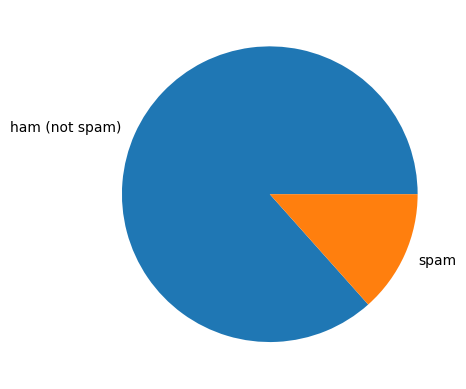

In [33]:
# percentage of spam and non-spam (ham)
print(round(data['Label'].value_counts(normalize=True) * 100, 1))

# visualizing the percentage of each class
labels = 'ham (not spam)', 'spam'
sizes = data['Label'].value_counts(normalize=True) * 100

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)


The chart above shows that the dataset is not balanced: 86.6% of messages are ham and 13.4 of messages are ham.

-------------
Data Cleaning
------------

#### Letter Case and Punctuaton
To avoid extra complication, I first remove all the punctuations and change all letters to lowercase in all messages (otherwise same word with different capitalization is counted multiple times)

In [34]:
#some example of messages including punctuations and capital letters
data.tail(20)

,Label,SMS
5552,ham,Have a safe trip to Nigeria. Wish you happines...
5553,ham,Hahaha..use your brain dear
5554,ham,Well keep in mind I've only got enough gas for...
5555,ham,Yeh. Indians was nice. Tho it did kane me off ...
5556,ham,Yes i have. So that's why u texted. Pshew...mi...
5557,ham,No. I meant the calculation is the same. That ...
5558,ham,"Sorry, I'll call later"
5559,ham,if you aren't here in the next &lt;#&gt; hou...
5560,ham,Anything lor. Juz both of us lor.
5561,ham,Get me out of this dump heap. My mom decided t...


As you see in the examples above, most messages include punctuations and capital letters

In [35]:
# removing punctuations and transforming every letter in every word to lower case
data['SMS'] = data['SMS'].str.lower()
data['SMS'] = data['SMS'].str.translate(str.maketrans('', '', string.punctuation))

In [37]:
# some example of messages after cleaning: without punctuations and all in small letters
data.tail(20)

,Label,SMS
5552,ham,have a safe trip to nigeria wish you happiness...
5553,ham,hahahause your brain dear
5554,ham,well keep in mind ive only got enough gas for ...
5555,ham,yeh indians was nice tho it did kane me off a ...
5556,ham,yes i have so thats why u texted pshewmissing ...
5557,ham,no i meant the calculation is the same that l...
5558,ham,sorry ill call later
5559,ham,if you arent here in the next ltgt hours imm...
5560,ham,anything lor juz both of us lor
5561,ham,get me out of this dump heap my mom decided to...


As you see in the examples above the punctuations (and all non alphanumeric letters) are removed and all words are now in small letters

#### Creating the Set of Unique Words (Vocabulary)

The idea is to find all unique words in all messages. They will be added to the dataset as the header of columns. After, I count the number of each word in each message. The number of counts for each word will be the value of the corresponding column for each message (each row in the dataset). Those coulmns will be the features to train and test the data for different algorthms.

In [38]:
# transforming each message from the SMS column into a list by splitting the string at the space character
data['SMS_split'] = data['SMS'].str.split()

First, I split each message to a list of words in the message, like th examples below 

In [39]:
data.head()

,Label,SMS,SMS_split
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


Then, I creat a list of all unique words in all messages

In [40]:
# creating a list of all words used in the messages (vocabulary)
vocabulary = []
for row in data['SMS_split']:
    for i in row:
        vocabulary.append(i)
        
vocabulary = list(set(vocabulary))

In [41]:
# some example of vocabularies
vocabulary[:10]

['walls',
 '46',
 'anyplaces',
 'public',
 'mailed',
 'american',
 'aint',
 'urgh',
 '151',
 'mate']

In [42]:
# number of all words
len(vocabulary)  

9661

In total there are 9661 unique words. Therefore, 9661 features for each message. And, the value of each feature is the count of that world in the message. 

In [43]:
# counting number of words from "Vocabulary" in each SMS
dict_count = {i: [0] * len(data['SMS_split']) for i in vocabulary}

for index, row in enumerate(data['SMS_split']):
    for j in row:
        dict_count[j][index] += 1

In [44]:
# converting ot dataframe
df_count = pd.DataFrame(dict_count)

In [45]:
#some examples of count dataframe
df_count.head()

,walls,46,anyplaces,public,mailed,american,aint,urgh,151,mate,...,hail,deal,proof,shirt,response,bathe,locks,ldn,0207,mum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Above are some examples of the new dataframe that will be added to the original dataframe 

#### Final dataset

In [46]:
# adding the label column to get final data set
data = pd.concat([data, df_count], axis='columns')

In [47]:
# some example of final data set
data.sample(5)

,Label,SMS,SMS_split,walls,46,anyplaces,public,mailed,american,aint,...,hail,deal,proof,shirt,response,bathe,locks,ldn,0207,mum
3268,ham,ok then i come n pick u at engin,"[ok, then, i, come, n, pick, u, at, engin]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1839,spam,hack chat get backdoor entry into 121 chat roo...,"[hack, chat, get, backdoor, entry, into, 121, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
254,ham,ups which is 3days also and the shipping compa...,"[ups, which, is, 3days, also, and, the, shippi...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1635,spam,eerie nokia tones 4u rply tone title to 8007 e...,"[eerie, nokia, tones, 4u, rply, tone, title, t...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
821,ham,good afternoon starshine hows my boytoy does h...,"[good, afternoon, starshine, hows, my, boytoy,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Above are some examples of the final dataset: 5572 rows (messages) and 9664 columns out of which one is the "label" and 9661 are the unique words

------------
Exploratory data analysis
-----

By exploring the data, I found the following 2 aspects to be different between spam and ham messages :
- number of words in a message
- most frequent words

#### Number of words in a message

Text(0.5, 0, 'Number of words in SMS')

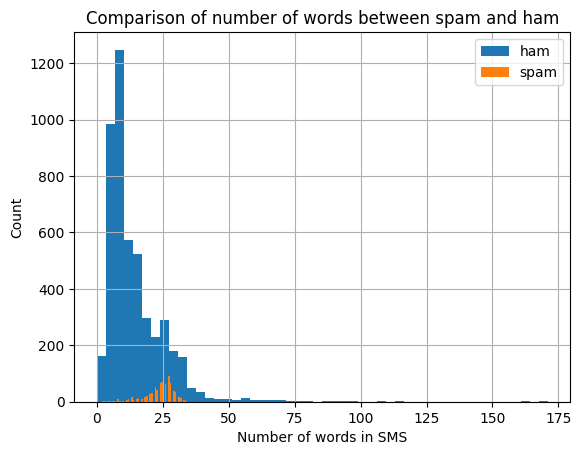

In [48]:
# counting and plotting the histogram of total number of words in each SMS for ham and SPAM messages 

data[data['Label']=='ham'].sum(axis=1, numeric_only=True).hist(bins=50, label='ham')
data[data['Label']=='spam'].sum(axis=1, numeric_only=True).hist(bins=50, label='spam')

plt.legend(loc="upper right")
plt.title("Comparison of number of words between spam and ham")
plt.ylabel('Count')
plt.xlabel('Number of words in SMS')

The histograms shows that, for ham messages the most common lenght of a message is about 10 words, while for spam message this value is more than 25.

#### Most common words in ham and spam messages

In [49]:
# finding the most frequent words in each class (ham or spam)
cols_words = data.columns.difference(['Label', 'SMS', 'SMS_split'])
X = data[cols_words]
y = data['Label']
print('\n **********20 most common words in ham messages: ************ \n', 
      X[y =='ham'].sum(axis=0).sort_values(ascending=False)[0:20])
print('\n **********20 most common words in spma messages: ************ \n', 
      X[y =='spam'].sum(axis=0).sort_values(ascending=False)[0:20])


 **********20 most common words in ham messages: ************ 
 i       2194
you     1841
to      1562
the     1129
a       1064
u        985
and      849
in       815
me       761
my       747
is       735
it       594
of       525
for      507
that     488
im       451
have     441
but      425
your     414
so       413
dtype: int64

 **********20 most common words in spma messages: ************ 
 to        689
a         378
call      347
you       287
your      263
free      216
the       204
for       203
now       189
or        188
2         173
is        158
txt       150
u         147
on        145
ur        144
have      135
from      128
mobile    123
and       122
dtype: int64


One can see that while for ham message the most common words are the expected ones (I, you, to, the, a, ...), for spam message, interestingly, among the 20 most common words one can find less expected words like: call, free, now, mobile.

This can be an indication that a good algorithm might be able to classify spam from ham messages by looking at the words in the message.


-------
Decision Tree Classifier:
------

First algorithm that I consider is a decision tree classifier. I first consider the basic algorithm and measure the accuracy (using cross vlaidation) as well as the execution time. 

In [50]:
# decision tree clasifier with default settings

clf_DT = DecisionTreeClassifier()

# to measure exceution time (with cross validation cv=3)
start = time.process_time()
# calculating cross validation scaore (cv=3) fro the model
clf_DT_score_cv= cross_val_score(clf_DT, X, y, cv=3)

print('Process time (CV=3): ', time.process_time() - start, 's \n')
print('Cross-validation scores: ', clf_DT_score_cv, '\n')

# calculating average cross validation score (cv=3)
clf_DT_score_cv_avg = np.mean(clf_DT_score_cv) 
print('Avergae of cross-validation scores: ', clf_DT_score_cv_avg)


Process time (CV=3):  9.664050277000001 s 

Cross-validation scores:  [0.96555436 0.9628433  0.9644588 ] 

Avergae of cross-validation scores:  0.9642854865626411


#### Hyperparameter tuning
After, I perform a hyperparameter tuning (using grid search) on two hyper parameters, namely criterion (gini or entropy) and class weight (none or balanced). 
Note that, since I am going to use the result of Decision tree model as my baseline, I don't perform a full hyperparameter optimization on all the parameters.

In [51]:
# performing grid search on criterion and class_weight
params = {
    'criterion': ['gini', 'entropy'], 
    'class_weight' : [None, 'balanced']
}

grid_DT = GridSearchCV(estimator=clf_DT,param_grid=params, cv=3).fit(X, y)

In [53]:
print('Best parameters: ', grid_DT.best_params_)
print('best score: ', grid_DT.best_score_)

Best parameters:  {'class_weight': None, 'criterion': 'gini'}
best score:  0.9639267744174962


The results show that the 'class_weight': None and 'criterion': 'gini' are the best hyperparameters. I measure once again the run time using the "best model": which shows that the model takes 9.4 s to run with accuracy of 0.96 (cross validation cv=3)

In [61]:
# measure time needed ot run the best model (with cross validation cv=3)
start = time.process_time()
clf_DT_score_cv= cross_val_score(grid_DT.best_estimator_, X, y, cv=3)
print('Process time (CV=3): ', time.process_time() - start, 's \n')

Process time (CV=3):  9.410705172000007 s 



As seen eralier, the calsses (spam vs ham) are not balanced in the dataset (about 87% ham vs 13% spam). Therefore, it is good that, in addiotin to the value of the accuracy, we also consider the reciever operation characterisitc (ROC curve of ture positve rate vs. false positive rate) and the aera under curve (AUC) value.

#### ROC plot

Below is a function that generates the ROC curves for a k-fold cross validation results and plots the mean ROC curve and caculates the average AUC value (with its standard deviation).

In [55]:
# function to plot ROC curve for all folds of cross validation + the mean values + the aera under curve (AUC) 
def ROC_curve(X, y, classifier, cv, plot_title):
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    # Run classifier with cross-validation and plot ROC curves
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots()
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train_index], y.iloc[train_index])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test_index],
            y.iloc[test_index],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic: " + plot_title,
    )
    ax.legend(loc="lower right")
    plt.show()
    return(mean_auc)

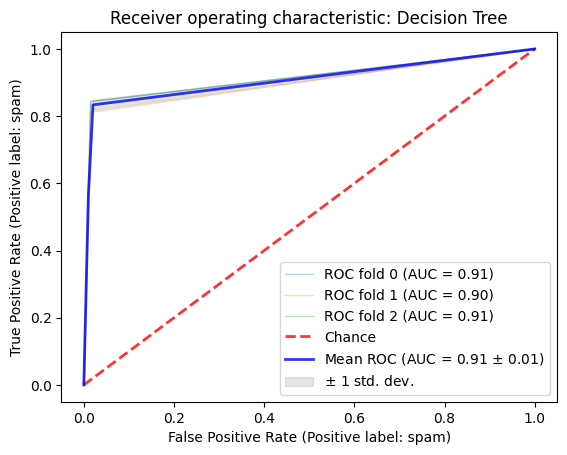

In [56]:
# plot ROC curve (results of cross validaiton) fro the best model
DT_ROC = ROC_curve(X, y, classifier=grid_DT.best_estimator_, cv=3, plot_title="Decision Tree")

One can see that fro decisoin tree, the ROC curve does not get very close to 1 in the top left corner (compared to othe algorithm that I explore below) and the avergae AUC value is 0.91.

Note that "spam" is considered the positive label.

-----------
Ada Boost Classifier
---------------

Second algorithm to consider is an ensemble Ada boost classifier (base estimator is decisoiin tree with max depth=1). I first consider the basic algorithm and measure the accuracy (using cross vlaidation) and the execution time. 

In [57]:
# decision tree clasifier with default settings
clf_AB = AdaBoostClassifier()

# to measure time needed ot run the model (with cross validation cv=3)
start = time.process_time()

# calculating cross validation scaore (cv=3) fro the model
clf_AB_score_cv= cross_val_score(clf_AB, X, y, cv=3)
print('Process time (CV=3): ', time.process_time() - start, 's \n')
print('Cross-validation scores: ', clf_AB_score_cv, '\n')

# calculating average cross validation score (cv=3)
clf_AB_score_cv_avg = np.mean(clf_AB_score_cv) 
print('Avergae of cross-validation scores: ', clf_AB_score_cv_avg)

Process time (CV=3):  40.755127066 s 

Cross-validation scores:  [0.967169   0.97092084 0.96068928] 

Avergae of cross-validation scores:  0.966259707593085



The reuslts show that the execution time is much longer than the decisoion tree (41s vs 9s) and the accuracy is slightly increased (0.97 vs 0.96).

#### Hyperparameter tuning

After, I perform a hyperparameter tuning (using grid search). 
Since the excution time is realtively alarge for the Adaboost model on my dataset, I only perform the optimization on two hyperparameters, namely number of estimators (number of tress) and learning rate.

In [58]:
# performing grid search on number of estimators and learning rate

params = {
    'n_estimators': [30, 50, 70, 90], 
    'learning_rate' : np.logspace(-2, 2, num=5, endpoint=True, base=2.0, dtype=None, axis=0)
}

grid_AB = GridSearchCV(estimator=clf_AB,param_grid=params, cv=3).fit(X, y)

In [59]:
print('Best parameters: ', grid_AB.best_params_)
print('best score: ', grid_AB.best_score_)

Best parameters:  {'learning_rate': 1.0, 'n_estimators': 90}
best score:  0.9712847691383507


the results of the hyper prameter tuning show that best model is with 'learning_rate': 1.0, 'n_estimators': 90.
I measure once again the run time, using the "best model": which shows that the model takes about 72 s to run with accuracy of 0.97 (cross validation cv=3). The execution time is further increased compared to the basic model since the number of estimators (trees) has increased.

In [62]:
# measure time needed ot run the best model (with cross validation cv=3)
start = time.process_time()
clf_AB_score_cv= cross_val_score(grid_AB.best_estimator_, X, y, cv=3)
print('Process time (CV=3): ', time.process_time() - start, 's \n')

Process time (CV=3):  71.83341137899993 s 



#### ROC plot

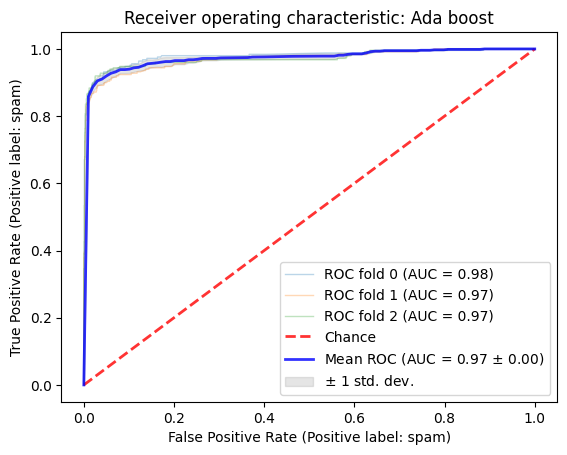

In [60]:
# plot ROC curve (results of cross validaiton) fro the best model
AB_ROC = ROC_curve(X, y, classifier=grid_AB.best_estimator_, cv=3, plot_title="Ada boost")

One can see that for Adaboost, the ROC curve looks much better thatn the one for decisoin tree, i.e., gets closer to 1 in the top eft corner  (meaning higher TPR for a relatively low FPR) and the avergae AUC value is 0.97 which is significantly increased compared to the decion tree clasifier (0.91).

Note that "spam" is considered the positive label.

-------------------
Support Vector Machine
--------------------

Third algorithm to consider is a support vector machine classifier (with radial basis function kernel, i.e., rbf). 
I first consider the basic algorithm and measure the accuracy (using cross vlaidation) and the execution time. 

In [63]:
clf_SVM = SVC()
start = time.process_time()
clf_SVM_score_cv= cross_val_score(clf_SVM, X, y, cv=3)
print('Process time (CV=3): ', time.process_time() - start, 's \n')
print('Cross-validation scores: ', clf_SVM_score_cv, '\n')
clf_SVM_score_cv_avg = np.mean(clf_SVM_score_cv) 
print('Avergae of cross-validation scores: ', clf_SVM_score_cv_avg)

Process time (CV=3):  145.65233821099991 s 

Cross-validation scores:  [0.9752422  0.97415186 0.97738288] 

Avergae of cross-validation scores:  0.9755923097835381


The reuslts show that the run time is much more than both decisoion tree and Adaboost classifiers(146s vs. 9s, 41s respectively) and the accuracy is slightly increased (0.98 vs. 0.96, 0.97 respectively).

#### Hyperparameter tuning

After, I perform a hyperparameter tuning (using grid search). Since, on my datset, the execution time is very large for the SVM model on my dataset, I perfom the optimization only on two hyper parameters, namely C (Regularization parameter) and class weight (no weight or balanced)

In [74]:
# performing grid search on number of estimators and learning rate

params = {
    'C': np.logspace(-5, 5, num=11, endpoint=True, base=2.0, dtype=None, axis=0),
    'class_weight': [None, 'balanced']
}

grid_SVM = GridSearchCV(estimator=clf_SVM,param_grid=params, cv=3).fit(X, y)

In [75]:
print('Best parameters: ', grid_SVM.best_params_)
print('best score: ', grid_SVM.best_score_)

Best parameters:  {'C': 0.5, 'class_weight': 'balanced'}
best score:  0.9797199630023155


the results of the hyper prameter tuning show that best model is with 'C': 0.5, 'class_weight': 'balanced'.
I measure once again the run time using the "best model": which shows that the model takes about 175 s to run with accuracy of 0.98 (cross validation cv=3). The run time is slightly increased compared t0 the basic model.

In [76]:
# measure time needed ot run the best model (with cross validation cv=3)
start = time.process_time()
clf_AB_score_cv= cross_val_score(grid_SVM.best_estimator_, X, y, cv=3)
print('Process time (CV=3): ', time.process_time() - start, 's \n')

Process time (CV=3):  174.96628243099985 s 



#### ROC plot

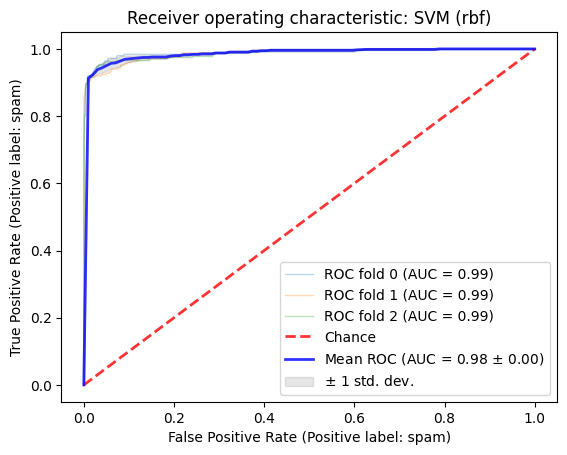

In [77]:
# plot ROC curve (results of cross validaiton) fro the best model
SVM_ROC = ROC_curve(X, y, classifier=grid_SVM.best_estimator_, cv=3, plot_title="SVM (rbf)")

One can see that for SVM, the ROC curve looks very good, i.e, very close to 1 in the top eft corner  and the avergae AUC value is 0.98 which is significantly increased compared to the decion tree clasifier (0.91) and is slighly higher than the one of Adaboost (0.97).

-------------
Discussion and Conclusion
--------------

Here is summary of results with 3 different algorthms: Note that results are from the "best model", i.e., outcome of the hyperparameter tuning and based on cross validation with cv=3:

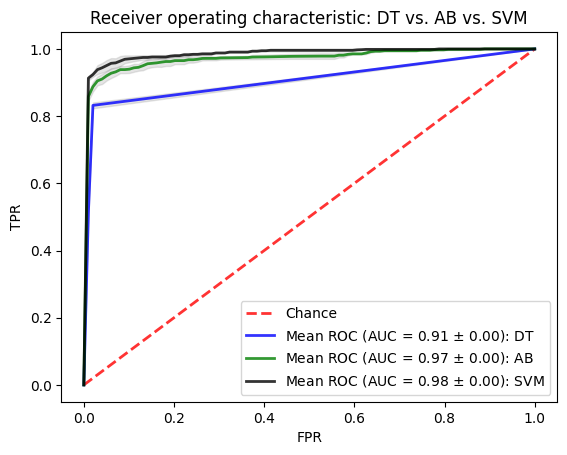

In [96]:
# to plot ROC of all 3 models in one figure for comparison

#3 models:
best_models = [grid_DT.best_estimator_, grid_AB.best_estimator_, grid_SVM.best_estimator_]
Model_name = ['DT', 'AB', 'SVM'] 
color_list = ['b', 'g', 'k']

fig, ax = plt.subplots()
for j, classifier in enumerate(best_models):
    fig1, ax1 = plt.subplots()
    fig1.set_figheight(0.1)
    fig1.set_figwidth(0.1)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    # Run classifier with cross-validation and plot ROC curves
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train_index], y.iloc[train_index])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test_index],
            y.iloc[test_index],
            name=None,
            alpha=0.3,
            lw=1,
            ax=ax1,
        )
        #interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    if j==0:
        ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=color_list[j],
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f): " % (mean_auc, std_auc) + Model_name[j],
        lw=2,
        alpha=0.8,
    )
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )
    
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic: DT vs. AB vs. SVM",
        ylabel= "TPR",
        xlabel = 'FPR'
    )
    ax1.set_visible(False)

ax.legend(loc="lower right")
ax.set_visible(True)


|  | Decision tree | Ada boost | SVM |
| --- | --- | --- | --- |
| Accuracy:| 0.96 | 0.97 | 0.98 |
| AUC:| 0.91 | 0.97 | 0.98 |
| Time:| 9.4 s | 71.8 s | 175.0 |




Based on these results, one can conclude that all 3 models have high accuracy and AUC values.
In addition, both Ada boost and SVM algorithms significantly improve the AUC value (compared to decisoiin tree) and therefore have comparatively superior classification performance (reaching 0.97-0.98 AUC value). The ROC curve above shows that the SVM model has slighly better performance compared to the Ada boost model.

However, both models (and especially the SVM models) require a significantly higher computational time for the training of the model compared to the deciosin tree algorithm. 

In conclusion, the choice of the model is a trade-off between the available computational resources and the required classification accuracy. 

As noted earlier, due to the large execution time needed for Adaboost and SVM models, I did not perform a full hyperparameter optimzation on all parameters. In order to further improve the performance of those models one can perform a more thorough hyperparameter tuning.